import libraries and load the data

In [1]:
# get the data 
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [4]:
!ls pubmed-rct/

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [8]:
import os 
for path,dir,files in os.walk("pubmed-rct/"):
  if path.startswith('pubmed-rct/.git'):
    pass
  else:
     print(f"there is {len(dir)} dirs  and {len(files)} files in {path}")

there is 5 dirs  and 1 files in pubmed-rct/
there is 0 dirs  and 3 files in pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
there is 0 dirs  and 3 files in pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign
there is 0 dirs  and 3 files in pubmed-rct/PubMed_200k_RCT
there is 0 dirs  and 3 files in pubmed-rct/PubMed_20k_RCT


In [9]:
for i in os.listdir("pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"):
 print("pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/" + i)

pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt


In [10]:
with open("pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt", "r") as f:
  test = f.readlines()

In [11]:
test[1:5]

['BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n']

In [13]:
test[1].split("\t")

['BACKGROUND',
 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n']

create function to preprocess the dataset

In [16]:
def create_target_text_dict(file):
  with open(f"pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/{file}.txt", "r") as f:
    data = f.readlines()
  abstract_lines = ""
  abstract_sample = []
  for line in data:
    if line.startswith("###"):
      abstract_lines = "" #new abstract 
      abstract_id = line
    elif line == "\n":
      for number,lin in enumerate(abstract_lines.splitlines()):
        abstract_dict = {}
        abstract_dict["line_number"] = number
        abstract_dict["target"] = lin.split("\t")[0]
        abstract_dict["text"] = lin.split("\t")[1]
      
        abstract_dict["total_lines"] = len(abstract_lines.splitlines())
        abstract_sample.append(abstract_dict)


    else:
      abstract_lines = abstract_lines + line
    
  return abstract_sample

In [19]:
train = create_target_text_dict("train")
test = create_target_text_dict("test")
valid = create_target_text_dict("dev")

convert to data frames with pandas

In [20]:
import pandas as pd
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
valid_df = pd.DataFrame(valid)

In [21]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,12
1,1,METHODS,A total of @ patients with primary knee OA wer...,12
2,2,METHODS,Outcome measures included pain reduction and i...,12
3,3,METHODS,Pain was assessed using the visual analog pain...,12
4,4,METHODS,Secondary outcome measures included the Wester...,12


In [23]:
train_df.describe(include="all")

,line_number,target,text,total_lines
count,180040.000000,180040,180040,180040.000000
unique,NaN,5,176946,NaN
top,NaN,METHODS,clinicaltrials.gov Identifier : NCT@ .,NaN
freq,NaN,59353,186,NaN
mean,5.894568,NaN,NaN,12.789136
std,4.127672,NaN,NaN,3.236095
min,0.000000,NaN,NaN,4.000000
25%,3.000000,NaN,NaN,11.000000
50%,6.000000,NaN,NaN,12.000000
75%,9.000000,NaN,NaN,15.000000


In [24]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

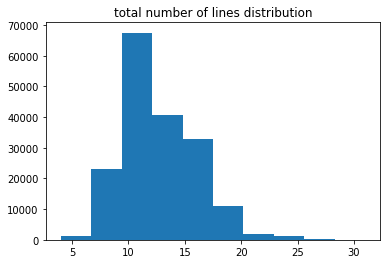

In [34]:
import matplotlib.pyplot as plt
plt.hist(train_df.total_lines)
plt.title("total number of lines distribution")
plt.show()

## model_0 baseline

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np  

In [27]:
model_0 = Pipeline([
    ("embeding", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

encoding labels

In [28]:
le = LabelEncoder()
labels_encoded = le.fit_transform(np.array(train_df["target"]) )
le.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [29]:
model_0.fit(train_df["text"].to_numpy(), labels_encoded)

Pipeline(steps=[('embeding', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
train_score = model_0.score(train_df["text"],labels_encoded)
valid_score = model_0.score(valid_df["text"],le.transform(valid_df["target"]))
test_score  = model_0.score(test_df["text"],le.transform(test_df["target"]))

In [39]:
models = []
score_dict = {"Train Accuracy": train_score, "Validition Accuracy":valid_score, "Test Accuracy": test_score}
model_0 = pd.DataFrame(score_dict , index=["Model_0"])

In [40]:
model_0

,Train Accuracy,Validition Accuracy,Test Accuracy
Model_0,0.751683,0.721832,0.716675
